# Movie Recommendation using Surprise

## What a Surprise!
Surprise provides the Matrix Factorization method necessary to implement Collaborative Filtering.

Surprise consists of three main modules.

* Dataset: A module for loading, preprocessing, and transforming data. Surprise can handle data in various formats. For example, CSV, tsv, pandas DataFrame, or a data file in a format you define yourself.

* Algorithm: A module for implementing recommendation algorithms. Surprise offers various algorithms such as SVD, NMF, PMF, Slope One, KNN Basic, KNN With Means, KNN With Z-Score, BaselineOnly, CoClustering.

* Evaluation: A module for evaluating the performance of recommendation algorithms. Surprise provides various evaluation metrics such as Cross-validation, Train-test split, Precision, Recall, F1-score, RMSE, MAE, MAPE, Coverage, etc.

## Matrix Factorization method for Collaborative Filtering
Matrix Factorization is a popular technique used in collaborative filtering to predict user-item ratings based on the previous ratings given by users. Collaborative Filtering is a type of recommendation system that relies on the past behavior of similar users/items to make recommendations.

Matrix Factorization is based on the idea of decomposing the user-item rating matrix into two lower-dimensional matrices: one representing users and the other representing items. The lower-dimensional representation captures the latent factors or features that influence a user's preference for an item. The factors may include, for example, the genre of the movie, the director, the actors, or the user's age, gender, etc.


In [71]:
import os
import random
import operator
import requests
import numpy as np
import pandas as pd
from scipy import sparse
import sys
from surprise import Dataset, Reader
from surprise import KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
import matplotlib.pyplot as plt
import seaborn as sns


In [72]:
# df = pd.read_csv('ratings.csv', skiprows=lambda i: i>0 and random.random() > 0.2)
df = pd.read_csv('ratings.csv')

#df_playlist=df_playlist.drop('timestamp',axis=1)
print(len(df))
#df=df[0:10000]
print(df['rating'].unique().tolist())
print(len(df['userId'].unique().tolist()))
print(len(df['movieId'].unique().tolist()))

100836
[4.0, 5.0, 3.0, 2.0, 1.0, 4.5, 3.5, 2.5, 0.5, 1.5]
610
9724


## pandas DataFrame to Surprise Dataset

In [73]:
reader = Reader(rating_scale=(0,10)) # rating scale range
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [74]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)
print(type(trainset))

<class 'surprise.trainset.Trainset'>


In [75]:
import itertools

for uid, iid, rating in itertools.islice(trainset.all_ratings(), 5):
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")
    
print()    
print(trainset.n_ratings,len(testset))

User 0 rated item 0 with a rating of 2.5
User 0 rated item 148 with a rating of 4.0
User 0 rated item 494 with a rating of 4.0
User 0 rated item 75 with a rating of 2.0
User 0 rated item 556 with a rating of 0.5

User 474 rated item 4046 with a rating of 4.0
User 312 rated item 16 with a rating of 4.0
User 32 rated item 527 with a rating of 4.0
User 380 rated item 68194 with a rating of 4.0
User 393 rated item 778 with a rating of 0.5

75627 25209


## SVD (Singular Value Decomposition)
* Extract latent features between users and items by decomposing the dataset into a low-dimensional space.
* It is computationally efficient compared to memory-based collaborative filtering algorithms, making it suitable for large datasets as well.
* Many parameters need to be adjusted, such as the number of items to recommend and how item similarity is calculated.

## KNNBasic (k-Nearest Neighbors)
* Based on the similarity of users and items, it finds the most similar users and items and recommends items that they might like.
* Computational efficiency is relatively high, making it suitable for small datasets.
* The number of parameters is relatively small, so it is easy to tune.

In [76]:
# Use the SVD algorithm to train the model
# algo = KNNBasic()
# algo = SVD()
algo = SVDpp()
algo.fit(trainset)

In [77]:
# Test the model on the testing set
predictions = algo.test(testset)

In [78]:
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User 474 rated item 4046 with a rating of 4.0
User 312 rated item 16 with a rating of 4.0
User 32 rated item 527 with a rating of 4.0
User 380 rated item 68194 with a rating of 4.0
User 393 rated item 778 with a rating of 0.5


The 'predictions' is a list of tuples of the form (user, item, actual_rating, predicted_rating, details). The predicted_rating is est value.

In [79]:
for prediction in predictions[0:5]:
    print(prediction)

user: 474        item: 4046       r_ui = 4.00   est = 3.29   {'was_impossible': False}
user: 312        item: 16         r_ui = 4.00   est = 4.25   {'was_impossible': False}
user: 32         item: 527        r_ui = 4.00   est = 4.19   {'was_impossible': False}
user: 380        item: 68194      r_ui = 4.00   est = 3.67   {'was_impossible': False}
user: 393        item: 778        r_ui = 0.50   est = 4.83   {'was_impossible': False}


In [80]:
# Print the performance metrics
accuracy.rmse(predictions)

RMSE: 0.8701


0.8700959119104394

In [81]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

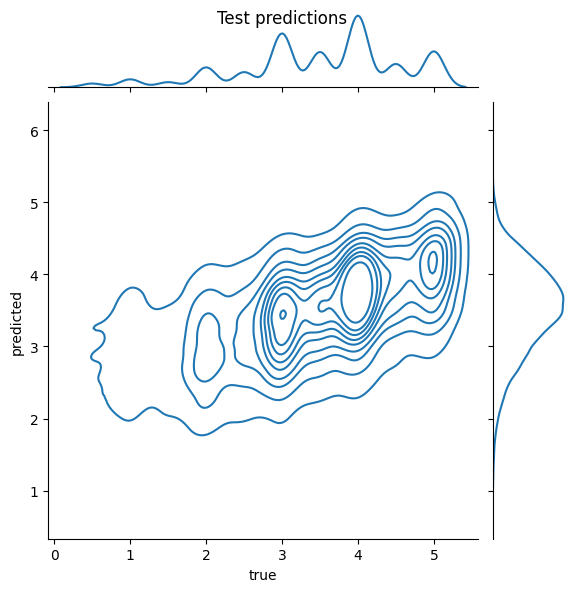

In [82]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

# Recommend unseen movies for test set users

In [83]:
users=list(set(uids))
print(users[0:5])

[1, 2, 3, 4, 5]


In [84]:
movie=pd.read_csv('movies.csv')
mapping = dict(zip(movie['movieId'],movie['title']))

In [85]:
# items which the user not yet evaluate
items = trainset.build_anti_testset()
for user in users[0:5]:
    user_items = list(filter(lambda x: x[0] == user, items))
    print()
    print(user,len(user_items))
    # generate recommendation
    recommendations = algo.test(user_items)
    recommendations.sort(key=operator.itemgetter(3), reverse=True)
    print(f"User {user} recommendations:")
    for r in recommendations[0:5]:
        print(f" [Title] {mapping[r[1]]}, [Estimated Rating] {round(r[3],3)}")


1 8554
User 1 recommendations:
 [Title] Lawrence of Arabia (1962), [Estimated Rating] 5.355
 [Title] There Will Be Blood (2007), [Estimated Rating] 5.154
 [Title] Guess Who's Coming to Dinner (1967), [Estimated Rating] 5.142
 [Title] Shawshank Redemption, The (1994), [Estimated Rating] 5.135
 [Title] Philadelphia Story, The (1940), [Estimated Rating] 5.133

2 8721
User 2 recommendations:
 [Title] Shawshank Redemption, The (1994), [Estimated Rating] 4.507
 [Title] Boondock Saints, The (2000), [Estimated Rating] 4.442
 [Title] Guess Who's Coming to Dinner (1967), [Estimated Rating] 4.403
 [Title] Lawrence of Arabia (1962), [Estimated Rating] 4.401
 [Title] Schindler's List (1993), [Estimated Rating] 4.393

3 8714
User 3 recommendations:
 [Title] Misery (1990), [Estimated Rating] 3.23
 [Title] Christmas Vacation (National Lampoon's Christmas Vacation) (1989), [Estimated Rating] 3.214
 [Title] Day of the Doctor, The (2013), [Estimated Rating] 3.139
 [Title] Secret of Roan Inish, The (1994